In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [6]:
# # Data inladen
df = pd.read_csv("final_df.csv")
print(df)

# # Apply One-Hot Encoding for the 'binary_trainingtype' column
# df = pd.get_dummies(df, columns=['binary_trainingtype'], drop_first=False)

# # Convert boolean columns to 0 and 1
# df[df.columns[df.columns.str.startswith('binary_trainingtype')]] = df[df.columns[df.columns.str.startswith('binary_trainingtype')]].astype(int)

# # Display the updated DataFrame
# print(df.head())

      ervaring  500_split  2k tijd  binary_trainingtype  binary_geslacht  \
0            1    104.600    379.9                    0                0   
1            1    104.700    379.9                    0                0   
2            1    104.300    379.9                    0                0   
3            1    104.000    379.9                    0                0   
4            1    104.100    379.9                    0                0   
...        ...        ...      ...                  ...              ...   
4309         0    120.400    484.1               101110                1   
4310         1     96.975    382.8                 1100                0   
4311         1    101.600    382.8                 1100                0   
4312         1     99.775    399.1               101111                0   
4313         1     94.250    377.0               101111                0   

      binary_gewichtsklasse  
0                         1  
1                         1

In [7]:
# https://www.youtube.com/watch?v=sIEH6SNNg7k 

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
# from sklearn.neural_network import MLPRegressor
# from sklearn.model_selection import GridSearchCV

# df_X = df.drop(columns=['2k tijd'])
# y = df['2k tijd']

# sc = MinMaxScaler()
# norm_df_X = sc.fit_transform(df_X)
# norm_y = sc.fit_transform(y.values.reshape(-1, 1))

# train_X, valid_X, train_y, valid_y = train_test_split(norm_df_X, norm_y, test_size=0.3, random_state=1)

# car_lm = MLPRegressor(hidden_layer_sizes=(64,32), 
#                       activation='relu',
#                       solver='adam',
#                       random_state=1,
#                       max_iter=3000)
# car_lm.fit(train_X, train_y.ravel())
# car_lm.score(valid_X, valid_y)

# param_grid = {
#     'hidden_layer_sizes': [(64,32), (128, 64)],
#     'solver': ['adam', 'lbfgs'],
#     'activation': ['relu'],
#     'max_iter': [3000, 5000]
# }

# gridSearch = GridSearchCV(MLPRegressor(), param_grid, 
#                           cv=5, n_jobs=-1,
#                           return_train_score=True)
# gridSearch.fit(train_X, train_y.ravel())

# print('Best score: ', gridSearch.best_score_,
#       '\nBest parameters: ', gridSearch.best_params_)

# display=['param_hidden_layer_sizes', 'param_solver', 'param_max_iter', 'mean_test_score', 'mean_train_score']
# print(pd.DataFrame(gridSearch.cv_results_)[display])

In [8]:
from sklearn.model_selection import train_test_split

# Eerst de data opschudden om bias te voorkomen
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Zorg ervoor dat elke ervaring, geslacht en gewichtsklasse in elke set vertegenwoordigd zijn
train_data = pd.DataFrame()
val_data = pd.DataFrame()
test_data = pd.DataFrame()

for ervaring in df['ervaring'].unique():
    for geslacht in df['binary_geslacht'].unique():
        for gewichtsklasse in df['binary_gewichtsklasse'].unique():
            subset = df[(df['ervaring'] == ervaring) & (df['binary_geslacht'] == geslacht) & (df['binary_gewichtsklasse'] == gewichtsklasse)]
            if not subset.empty:
                temp_train, temp_temp = train_test_split(subset, test_size=0.3, random_state=42)
                temp_val, temp_test = train_test_split(temp_temp, test_size=0.3, random_state=42)
                train_data = pd.concat([train_data, temp_train])
                val_data = pd.concat([val_data, temp_val])
                test_data = pd.concat([test_data, temp_test])

# Reset indexen
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Controleren op juiste verdeling
print(f"Trainingsdata: {len(train_data)} rijen")
print(f"Validatiedata: {len(val_data)} rijen")
print(f"Testdata: {len(test_data)} rijen")

X_train = train_data.drop(columns=['2k tijd'])
y_train = train_data['2k tijd']
X_val = val_data.drop(columns=['2k tijd'])
y_val = val_data['2k tijd']
X_test = test_data.drop(columns=['2k tijd'])
y_test = test_data['2k tijd']

Trainingsdata: 3018 rijen
Validatiedata: 905 rijen
Testdata: 391 rijen


Validation MSE: 112.76
Validation R^2: 0.89
Test MSE: 116.63
Test R^2: 0.89
   Actual 2k tijd  Predicted 2k tijd  Difference
0           427.7         425.290081    2.409919
1           420.5         426.287535   -5.787535
2           418.6         419.809892   -1.209892
3           427.7         425.752208    1.947792
4           427.7         429.758909   -2.058909
5           420.5         425.966265   -5.466265
6           421.9         425.771876   -3.871876
7           449.0         425.191347   23.808653
8           431.6         426.316276    5.283724
9           431.6         425.031490    6.568510


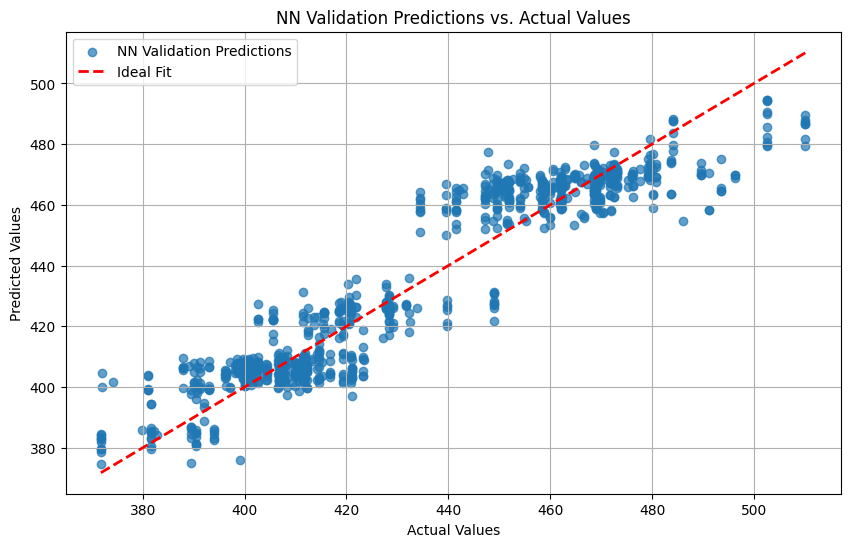

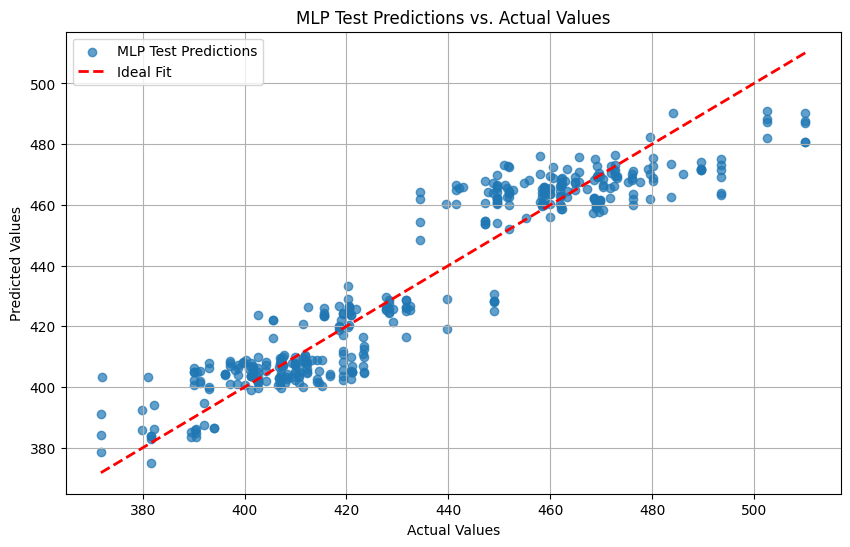

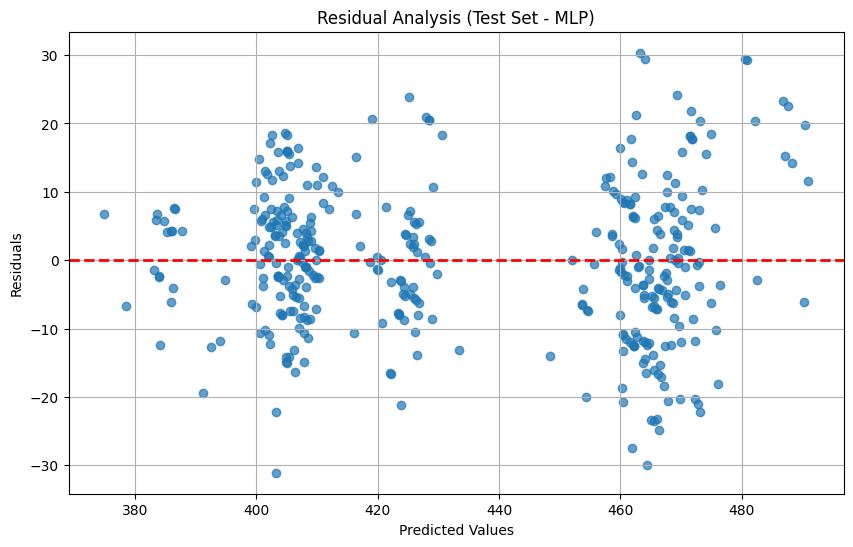

In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px

# Standardize the features
scaler = StandardScaler()
scaler.fit(X_train)  # Fit on training data only
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Create and train the MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(25, 20, 15), activation='identity', solver='adam', max_iter=2000, random_state=42)
mlp.fit(X_train_scaled, y_train)

# Validate the model
y_val_pred = mlp.predict(X_val_scaled)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {val_mse:.2f}")
print(f"Validation R^2: {val_r2:.2f}")

# Evaluate on test data
y_test_pred = mlp.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MSE: {test_mse:.2f}")
print(f"Test R^2: {test_r2:.2f}")

# Get the predicted values on the test set
y_test_pred = mlp.predict(X_test_scaled)

# Create a DataFrame to compare the actual vs predicted values
results = pd.DataFrame({
    'Actual 2k tijd': y_test,
    'Predicted 2k tijd': y_test_pred,
    'Difference': y_test - y_test_pred
})

# Display a few examples
print(results.head(10))  # You can adjust the number of rows displayed


# Plot 1: Predictions vs Actual for Validation Set (NN)
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.7, label='NN Validation Predictions')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', linewidth=2, label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('NN Validation Predictions vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Predictions vs Actual for Test Set (MLP)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, label='MLP Test Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('MLP Test Predictions vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Residuals for Test Set (MLP)
residuals_mlp = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals_mlp, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis (Test Set - MLP)')
plt.grid(True)
plt.show()

data = pd.DataFrame()
data['x'] = y_test
data['y'] = y_test_pred
p = px.scatter(data,x='x',y='y')
p.show()